# Script to scan the PSSS camera position
### Purpose:
To set or confirm the camera is positioned with the measured spectrum in the centre of the spectral integration window

Contact christopher.arrell@psi.ch

In [1]:
import epics as ep
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from collections import deque
%matplotlib inline
from IPython.display import clear_output, display

## Setup and functions setup

In [2]:
PSSS_spectrum_name = 'SARFE10-PSSS059:SPECTRUM_Y'
PSSS_e_axis_name = 'SARFE10-PSSS059:SPECTRUM_X'
PSSS_cam_x_PV_name = 'SARFE10-PSSS059:MOTOR_X5.VAL'

PSSS_spectrum_PV = ep.PV(PSSS_spectrum_name)
PSSS_e_axis_PV = ep.PV(PSSS_e_axis_name)
PSSS_cam_x_PV = ep.PV(PSSS_cam_x_PV_name)

def set_PSSS_camera_x(pos):
    PSSS_cam_x_PV.put(pos, wait=True)

def PSSS_camera_x_scan(Energy_range, NumShots):
        
    Spectrum_scan = []
            
    for pos in Cam_range:
        set_PSSS_camera_x(pos)  
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PSSS_spectrum_PV.add_callback(callback=on_value_change, pv =PSSS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        Spectrum_scan.append(np.array(Spectrum_this_energy))
        
    return(np.array(Spectrum_scan))

def gaus(x,a,x0,sigma,offset):
    return offset +a*np.exp(-(x-x0)**2/(2*sigma**2))

## User inputs - define travel range of camera
It is unlikely these values need to be changed

In [7]:
Cam_x_from = -17
Cam_x_to = -11
steps = 20
NumShots= 100

Cam_range = np.linspace(Cam_x_from, Cam_x_to, steps)

## Scan and take data

In [8]:
Scan_spec = PSSS_camera_x_scan(Cam_range,NumShots)

## Plot and return central position
Note due to the integration ROI the projected signal should have hard edges

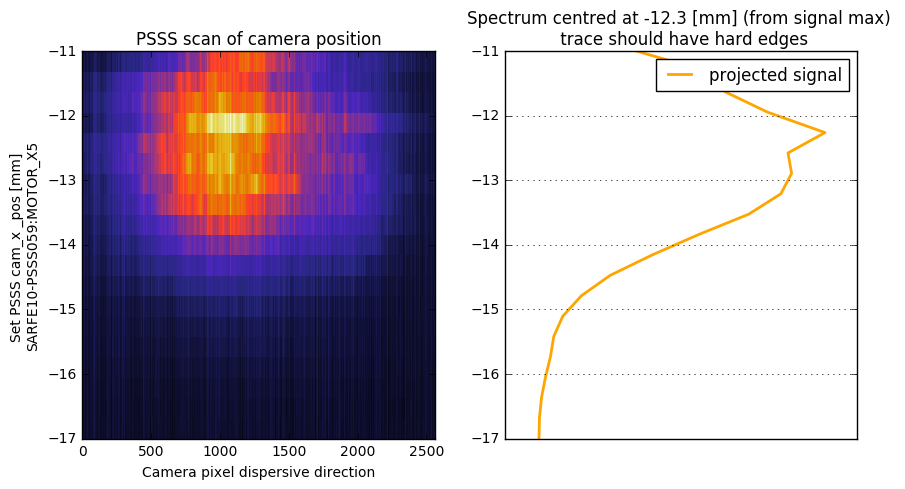

In [9]:
projection = Scan_spec.mean(axis=1).mean(axis=1)
signal_centre = Cam_range[np.argmax(projection)]
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('PSSS scan of camera position')
plt.pcolormesh(np.arange(0,Scan_spec.shape[2]), Cam_range, Scan_spec.mean(axis=1),cmap='CMRmap')
plt.xlim([0,Scan_spec.shape[2]])
plt.xlabel('Camera pixel dispersive direction')
plt.ylabel('Set PSSS cam_x _pos [mm] \n'+PSSS_cam_x_PV_name[0:-4])
plt.subplot(122)
plt.plot(projection,Cam_range,linewidth = 2, color = 'orange',label ='projected signal')
plt.title('Spectrum centred at %.1f [mm] (from signal max) \n trace should have hard edges'%signal_centre)
plt.xticks([])
plt.legend()
plt.grid(True)

## Set max position
Cell below will push the maximum position to the PSSS camera

In [10]:
set_PSSS_camera_x(signal_centre)